# Plate Reader Growth Rate - Fig S5

The goal of this notebook is to compare: 1) relative growth rates measured in the turbidostat (within a mixed population, and inferred by sequencing) to 2) relative growth rates measured for individual knockdowns in monoculture in a plate reader.

The plate reader assay was performed as follows:
Transformed sgRNAs against metK or glyA into MG1655 + dCas9 (gAM-130). WT-like growth control is Rand42.
Grew overday in LB + 35 Kan, washed 2x into M9 + 35 Kan and diluted 1:200. Grew overnight.
Adaptation step: Washed into M9 + 35 Kan + 50 ng/mL ATc 2x and diluted to OD 0.005. Grew 5.5 hours
Beginning the assay in 96 well plates: Diluted to OD 0.005 into M9 + 35 Kan + 50 ng/mL ATc.
Into Victor plate reader at 37C 40 cycles.
Data correlates well with turbidostat relative growth rates.

Written by Ryan Otto

Updated 7/23/20

## Import useful libraries

In [1]:
import pandas as pd # Data organization
import numpy as np # Data organization
import matplotlib.pyplot as plt # Plotting function
from scipy import stats # For linear regression and sem calculations
import datetime # For timepoint calculations
# Render figures in notebook
%matplotlib inline

## Establish paths and variables unique to this analysis

In [2]:
input_path = 'inputs/' # General path to input files
growth_path = 'outputs/20200923_df_growth_Glu.csv' # Path to turbidostat growth rate data
figure_path = 'Figures/' # General path for saving figures

Reps = 3 # Number of replicate measurements per well per timepoint
Timepoints = 40 # How many measurements were taken -- can use this to truncate a death phase near the end
genes = ['metK', 'glyA'] # List of genes to be analyzed
file_list = ['20200304_plate_reader_metK_glyA.txt', '20200307_plate_reader_metK_glyA.txt'] # Files to be analyzed

# Assign wells to samples in dictionary. The keys wells_dict should be the eight-digit date on each file in
# file_list. Each of the values in wells_dict will be another dictionary, this time with keys being the guides
# analyzed in each of these files. A non-targeting Rand42 guide should be present in each of these subdictionaries,
# and it's useful to tag this with the date as well to distinguish between different controls.
wells_dict = {}
wells_dict['20200304'] = {'Rand42_20200304':['E11', 'F11', 'G11'], 'metK1-MM7':['B02', 'B03', 'B04'], 
                          'metK1-MM6':['B05', 'B06', 'B07'], 'metK1-MM8':['B08', 'B09', 'B10'], 
                          'metK1-MM10':['C02', 'C03', 'C04'], 'metK1-MM12':['C05', 'C06', 'C07'], 
                          'metK1-MM14':['C08', 'C09', 'C10'], 'metK3-C':['D02', 'D03', 'D04'], 
                          'metK3-MM2':['D05', 'D06', 'D07'], 'metK3-MM3':['D08', 'D09', 'D10'], 
                          'metK3-MM5':['E02', 'E03', 'E04'], 'metK3-MM7':['E05', 'E06', 'E07'], 
                          'metK3-MM11':['E08', 'E09', 'E10'], 'glyA1-C':['F02', 'F03', 'F04'], 
                          'glyA1-MM6':['F08', 'F09', 'F10'], 'glyA1-MM12':['G02', 'G03', 'G04'], 
                          'glyA1-MM13':['G05', 'G06', 'G07'], 'glyA3-C':['G08', 'G09', 'G10'], 
                          'glyA3-MM2':['B11', 'C11', 'D11']}

wells_dict['20200307'] = {'Rand42_20200307':['C06', 'C07', 'C08'], 'glyA3-MM14':['C09', 'C10', 'C11'], 
                        'glyA3-MM12':['D03', 'D04', 'D05'], 'glyA3-MM9':['D06', 'D07', 'D08'], 
                        'glyA3-MM7':['D09', 'D10', 'D11'], 'glyA3-MM6':['E03', 'E04', 'E05'], 
                        'glyA3-MM4':['E06', 'E07', 'E08'], 'glyA1-MM11':['E09', 'E10', 'E11'], 
                        'glyA1-MM8':['F03', 'F04', 'F05'], 'metK3-MM8':['F06', 'F07', 'F08'], 
                        'metK1-C':['F09', 'F10', 'F11']}

date = '20200923' # Date for output files

## Import data

In [3]:
# Import turbidostat growth rate data
turbidostat_growth = pd.read_csv(growth_path, index_col=0, parse_dates=True)
turb_growth_dict = {}
turb_sem_dict = {}
for gene in genes:
    turb_growth_dict[gene] = {}
    turb_growth_dict[gene]['1'] = turbidostat_growth['mean'].filter(like=gene + '_1', axis=0)
    turb_growth_dict[gene]['3'] = turbidostat_growth['mean'].filter(like=gene + '_3', axis=0)
    turb_sem_dict[gene] = {}
    turb_sem_dict[gene]['1'] = turbidostat_growth['sem'].filter(like=gene + '_1', axis=0)
    turb_sem_dict[gene]['3'] = turbidostat_growth['sem'].filter(like=gene + '_3', axis=0)

# Import plate reader raw data
raw_data = {}
data_dict = {}
data_dict_log = {}
for file_name in file_list:
    file_date = file_name[0:8]
    raw_data[file_date] = []
    with open(input_path + file_name, 'r') as FI:
        for line in FI:
            sp = line.split('\t')
            if sp[0] == '1':
                raw_data[file_date].append(line)

    for line in raw_data[file_date]:
        sp = line.split('\t')
        TP = sp[1] # Timepoint recorded in file
        Loc = sp[2] # Location in 96 well plate
        growth_rates = []
        if int(TP) <= Timepoints:
            for guide in wells_dict[file_date]:
                if Loc in wells_dict[file_date][guide]:
                    if guide not in data_dict.keys():
                        data_dict[guide] = {}
                        data_dict_log[guide] = {}
                        for rep in range(Reps):
                            data_dict[guide][rep] = {}
                            data_dict_log[guide][rep] = {}
                    for rep in range(Reps):
                        growth_rates.append(float(sp[5 + (2*rep)][0:5]))
                    data_dict[guide][wells_dict[file_date][guide].index(Loc)][int(TP)-1] = growth_rates
                    data_dict_log[guide][wells_dict[file_date][guide].index(Loc)][int(TP)-1] = np.log2(growth_rates)

In [4]:
# Normalizing data by subtracting background from three timepoints in each well
data_dict_sub = {}
data_dict_log_sub = {}
for guide in data_dict.keys():
    data_dict_sub[guide] = {}
    data_dict_log_sub[guide] = {}
    for rep in range(Reps):
        data_dict_sub[guide][rep] = {}
        data_dict_log_sub[guide][rep] = {}
    
        for TP in data_dict[guide][rep].keys():
            well_background = [np.mean([x, y, z]) for x, y, z in 
                               zip(data_dict[guide][rep][0], data_dict[guide][rep][1], data_dict[guide][rep][2])]
            
            data_dict_sub[guide][rep][TP] = [x - y for x, y in zip(data_dict[guide][rep][TP], well_background)]
            
            data_dict_log_sub[guide][rep][TP] = [np.log2(x-y) for x, y in 
                                                 zip(data_dict[guide][rep][TP], well_background)]

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log2
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2


In [5]:
# Calculating the time gap between data points
FMT = '%H:%M:%S.%f' # Datetime formatting
gap1 = []
gap2 = []
gap3 = []
for file_name in file_list:
    file_date = file_name[0:8]
    rep1time = []
    rep2time = []
    rep3time = []
    for n, line in enumerate(raw_data[file_date]):
        sp = line.split('\t')
        if int(sp[0]) == 1:
            rep1time.append(datetime.datetime.strptime(sp[4], FMT))
            rep2time.append(datetime.datetime.strptime(sp[6], FMT))
            rep3time.append(datetime.datetime.strptime(sp[8], FMT))
    rep1min = np.zeros(len(rep1time))
    rep2min = np.zeros(len(rep2time))
    rep3min = np.zeros(len(rep3time))
    # Time of each measurement in minutes
    for i in range(len(rep1time)):
        rep1min[i] = rep1time[i].hour*60 + rep1time[i].minute + np.true_divide(rep1time[i].microsecond, 60000000)
    for i in range(len(rep2time)):
        rep2min[i] = rep2time[i].hour*60 + rep2time[i].minute + np.true_divide(rep2time[i].microsecond, 60000000)
    for i in range(len(rep3time)):
        rep3min[i] = rep3time[i].hour*60 + rep3time[i].minute + np.true_divide(rep3time[i].microsecond, 60000000)

    # Difference in time between measurements
    temp_gap1 = [x - y for x, y in zip(rep2min, rep1min)]
    temp_gap2 = [x - y for x, y in zip(rep3min, rep2min)]
    temp_gap3 = [x - y for x, y in zip(rep1min[96:], rep3min[:-96])] # Shift the frame for Reps 1 and 3

    gap1 = np.concatenate((gap1, temp_gap1))
    gap2 = np.concatenate((gap2, temp_gap2))
    gap3 = np.concatenate((gap3, temp_gap3))

# Fixes for shift in day on overnight runs
for i, value in enumerate(gap1):
    if value < 0:
        gap1[i] += 24*60 # Number of minutes in a day
for i, value in enumerate(gap2):
    if value < 0:
        gap2[i] += 24*60
for i, value in enumerate(gap3):
    if value < 0:
        gap3[i] += 24*60

avg_gap1 = np.mean(gap1)
avg_gap2 = np.mean(gap2)
avg_gap3 = np.mean(gap3)

print ('Gap1 = ' + str(avg_gap1) + ' minutes')
print ('Gap2 = ' + str(avg_gap2) + ' minutes')
print ('Gap3 = ' + str(avg_gap3) + ' minutes')

# Use average distance to create a representative timepoints array
TimeGap = 0 + avg_gap1 + avg_gap2 + avg_gap3
TStandard = range(Timepoints)
TRep1 = [x*TimeGap for x in TStandard]
TRep2 = [x+avg_gap1 for x in TRep1]
TRep3 = [x+avg_gap2 for x in TRep2]
TPs = sorted(TRep1 + TRep2 + TRep3)
TPs = np.true_divide(np.array(TPs), 60) # Puts in hours

Gap1 = 11.9571541015625 minutes
Gap2 = 11.957152061631943 minutes
Gap3 = 15.300629896723647 minutes


## Visualize growth in all wells

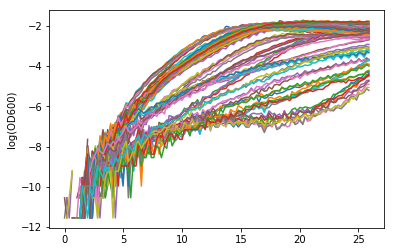

In [6]:
for guide in data_dict_log_sub.keys():
    for rep in range(Reps):
        plt.plot(TPs, np.hstack(data_dict_log_sub[guide][rep].values()))
plt.ylabel('log(OD600)')
plt.show()

## Fit an exponential growth rate

Here we take the log of the OD600 data, and perform a linear fit over a fixed OD range.

We also fit a second measure of growth, the area-under-the-curve (AUC) over the entire growth range. This measure captures changes in growth rate, but also variation in lag time, and the OD reached at saturation

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


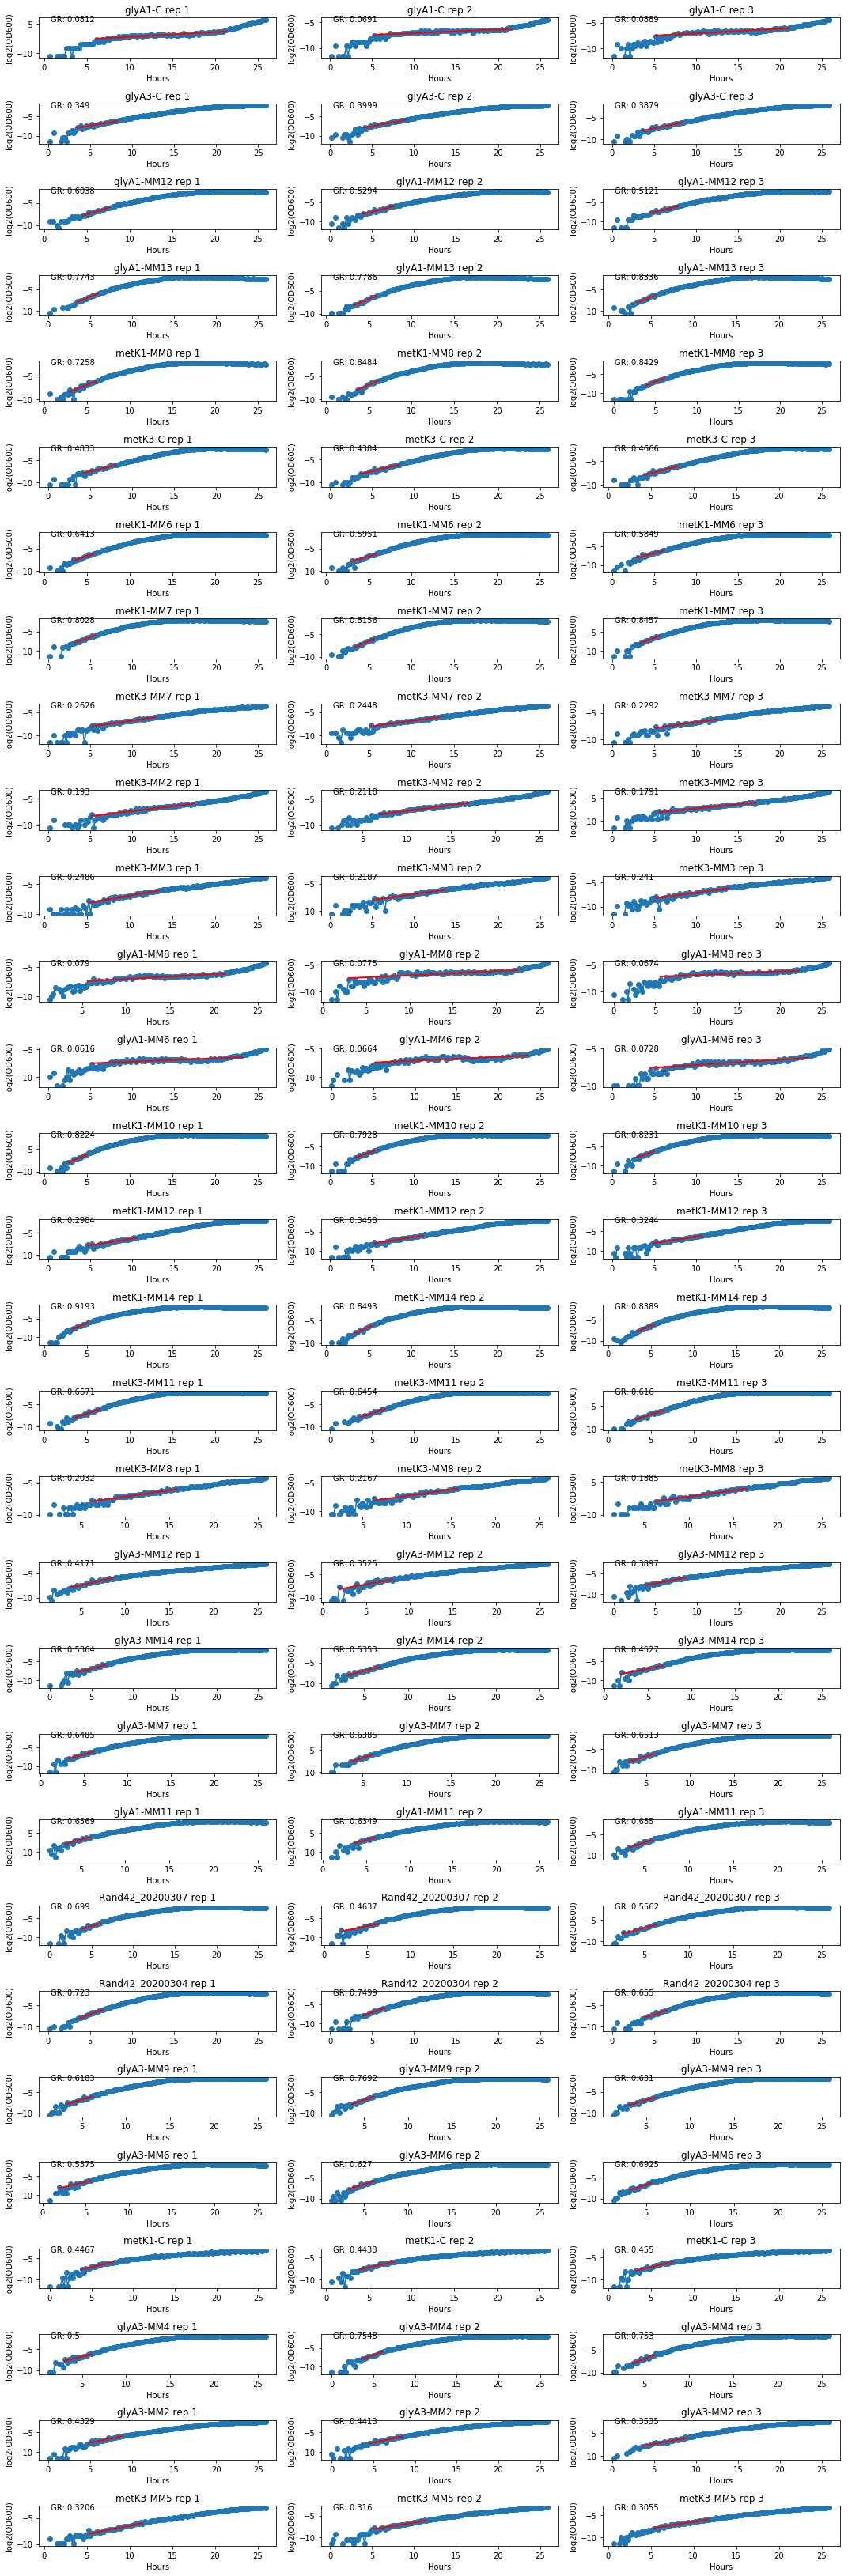

In [7]:
# Fit data according to linear range
gr_dict = {} # Growth rate dictionary
area_dict = {}
k = 1

fig = plt.figure(figsize=(15, 60))
for guide in data_dict_log_sub.keys():
    gr_dict[guide] = np.zeros(Reps)
    area_dict[guide] = np.zeros(Reps)
    for rep in range(Reps):
        FW = np.hstack(data_dict_log_sub[guide][rep].values())
        FW_noBS = np.hstack(data_dict_log[guide][rep].values())
        x = []
        y = []
        xA = []
        yA = []
        RI = np.where(np.logical_and(FW>=-8, FW<=-6)) # Range index locations
        for index in np.hstack(RI):
            x.append(TPs[index])
            y.append(FW[index])
        if len(y) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            Log_OD_pos = FW_noBS + abs(min(FW_noBS)) # Shifts data to be positive
            area = np.trapz(Log_OD_pos, TPs) # Integrates whole growth range
            gr_dict[guide][rep] = slope
            area_dict[guide][rep] = abs(area)
        else:
            slope, intercept, r_value, p_value, std_err = 0, 0, 0, 0, 0
            Log_OD_pos = FW_noBS + abs(min(FW_noBS)) # Shifts data to be positive
            area = np.trapz(Log_OD_pos, TPs) # Integrates whole growth range
            gr_dict[guide][rep] = slope
            area_dict[guide][rep] = abs(area)

        ax = fig.add_subplot(40, 3, k)
        plt.plot(TPs, FW, label=value, marker='o')
        plt.text(0.05, 0.9, 'GR: ' + str(np.round(gr_dict[guide][rep], 4)), transform=ax.transAxes)

        try:
            x = np.array(x)
            plt.plot(x, slope*x + intercept, '-r', linewidth=2)
        except:
            print(guide + ' can not fit line')
            print(str(x) + '   slope: ' + str(slope) + '   intercept: ' + str(intercept))
        plt.title(guide + ' rep ' + str(rep+1))
        plt.xlabel('Hours')
        plt.ylabel('log2(OD600)')
        k = k + 1
    plt.tight_layout()
plt.show()

In [8]:
# Average growth data and plot points
# Initialize dictionaries
mean_gr_dict = {}
sem_gr_dict = {}
mean_area_dict = {}
sem_area_dict = {}
gr_labels = []
for guide in gr_dict.keys():
    temp_gr = gr_dict[guide]
    temp_area = area_dict[guide]

    mean_gr = np.mean(np.array(temp_gr))
    sem_gr = stats.sem(temp_gr)
    mean_area = np.mean(np.array(temp_area))
    sem_area = stats.sem(temp_area)

    # Replace not at number nan with 0
    if str(mean_gr) == 'nan':
        mean_gr = np.mean(np.nan_to_num(np.array(temp_gr)))
    if str(sem_gr) == 'nan':
        sem_gr = stats.sem(np.nan_to_num(np.array(temp_gr)))
    if str(mean_area) == 'nan':
        mean_area = np.mean(np.nan_to_num(np.array(temp_area)))
    if str(sem_area) == 'nan':
        sem_area = stats.sem(np.nan_to_num(np.array(temp_area)))
    # Save calculated values into a dictionary
    mean_gr_dict[guide] = mean_gr
    sem_gr_dict[guide] = sem_gr
    mean_area_dict[guide] = mean_area
    sem_area_dict[guide] = sem_area

In [9]:
# Normalize to Rand42 sgRNA effect
# Initialize dictionaries
norm_gr_dict = {}
norm_area_dict = {}
norm_gr_sem_dict = {}
norm_area_sem_dict = {}
for guide in mean_gr_dict.keys():
    for file_name in file_list:
        file_date = file_name[0:8]
        if guide in wells_dict[file_date].keys():
            norm_gr_dict[guide] = mean_gr_dict[guide] - mean_gr_dict['Rand42_' + file_date]
            norm_area_dict[guide] = mean_area_dict[guide] - mean_area_dict['Rand42_' + file_date]
            norm_gr_sem_dict[guide] = (sem_gr_dict[guide]**2 + sem_gr_dict['Rand42_' + file_date]**2)**(0.5)
            norm_area_sem_dict[guide] = (sem_area_dict[guide]**2 + sem_area_dict['Rand42_' + file_date]**2)**(0.5)

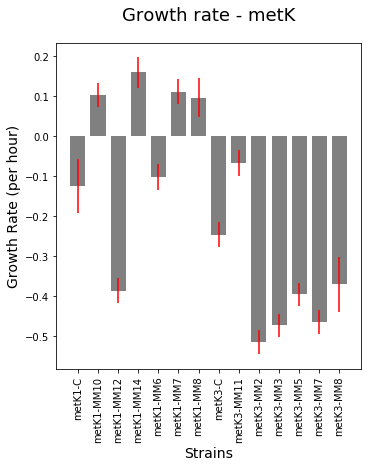

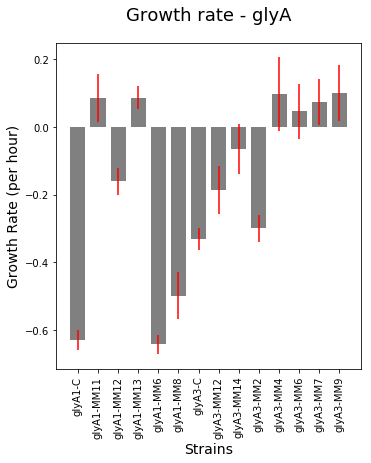

In [10]:
# Plot growth rates
for i, gene in enumerate(genes):
    plt.figure(figsize=(12, 6))
    growth_rate = []
    growth_sem = []
    label = []
    ind = 0
    width = 0.75
    for guide in sorted(norm_gr_dict.keys()):
        if guide.startswith(gene):
            growth_rate.append(norm_gr_dict[guide])
            growth_sem.append((norm_gr_sem_dict[guide]))
            label.append(guide)
            ind += 1
    ind = np.arange(ind)
    plt.subplot(1, 2, i + 1)
    plt.bar(ind + width, growth_rate, width, color='grey', ecolor='r', yerr=growth_sem)
    plt.xticks(ind + width, label, rotation=90)
    plt.xlabel('Strains', fontsize = 14)
    plt.ylabel('Growth Rate (per hour)', fontsize=14)
    plt.title('Growth rate - ' + gene, y=1.05, fontsize=18)
    plt.show()

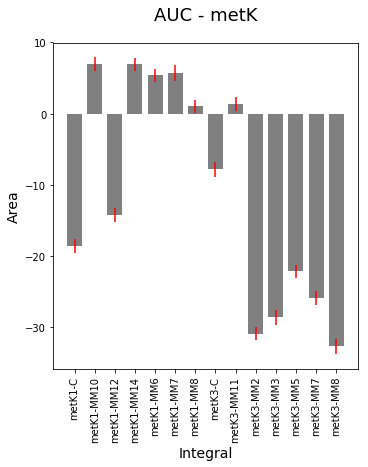

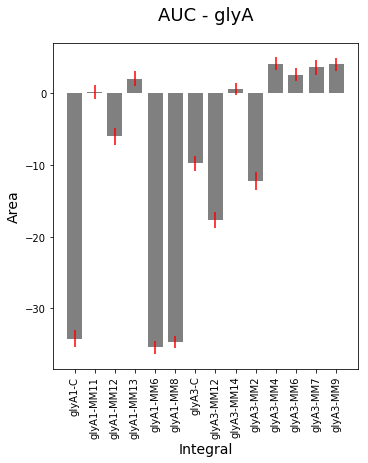

In [11]:
# Plot area under growth curve
for i, gene in enumerate(genes):
    plt.figure(figsize=(12, 6))
    label = []
    area_array = []
    area_sem = []
    ind = 0
    width = 0.75
    for guide in sorted(norm_gr_dict.keys()):
        if guide.startswith(gene):
            area_array.append(norm_area_dict[guide])
            area_sem.append((norm_area_sem_dict[guide]))
            label.append(guide)
            ind += 1
    ind = np.arange(ind)
    plt.subplot(1, 2, i + 1)
    plt.bar(ind + width, area_array, width, color='grey', ecolor='r', yerr=area_sem)
    plt.xticks(ind + width, label, rotation=90)
    plt.xlabel('Integral', fontsize=14)
    plt.ylabel('Area', fontsize=14)
    plt.title('AUC - ' + gene, y=1.05, fontsize=18)
    plt.show()

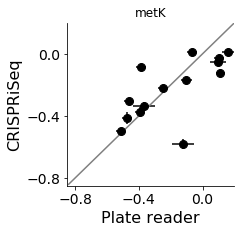

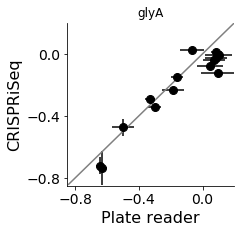

In [12]:
# Figures S5H and S5I
# Correlate plate reader (exponential growth rates) and turbidostat data for all guides with both measurements
for gene in genes:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    for guide in norm_gr_dict.keys():
        if guide.startswith(gene):
            family = guide[4]
            MM = guide[6:]
            if gene in genes:
                if MM != 'C':
                    turb_growth = turb_growth_dict[gene][family].filter(like='B_' + MM, axis=0)
                    turb_sem = turb_sem_dict[gene][family].filter(like='B_' + MM, axis=0)
                else:
                    turb_growth = turb_growth_dict[gene][family].filter(like='_' + MM, axis=0)
                    turb_sem = turb_sem_dict[gene][family].filter(like='_' + MM, axis=0)

                ax.errorbar(norm_gr_dict[guide], turb_growth, xerr=norm_gr_sem_dict[guide], 
                               yerr=turb_sem, fmt='o', color='k', ms=8)
    ax.plot([-0.84, 0.4], [-0.84, 0.4], color='gray', lw=1.5)
    ax.set_xlim([-0.85, 0.2])
    ax.set_ylim([-0.85, 0.2])
    ax.tick_params(labelsize=14)
    ax.set_xticks([-0.8, -0.4, 0])
    ax.set_yticks([-0.8, -0.4, 0])
    ax.set_xlabel('Plate reader', fontsize=16)
    ax.set_ylabel('CRISPRiSeq', fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(gene)
    if gene == 'metK':
        plt.savefig(figure_path + date + '_plate_reader_metK_FigS5H.pdf', transparent=True)
    elif gene == 'glyA':
        plt.savefig(figure_path + date + '_plate_reader_glyA_FigS5I.pdf', transparent=True)
    else:
        plt.savefig(figure_path + date + '_plate_reader_' + gene + '.pdf', transparent=True)
    plt.show()